## Implementation of the paper 'Image noise types recognition using convolutional neural network with principal components analysis'

#### doi: 10.1049/iet-ipr.2017.0374
##### Hui Ying Khaw1
##### Foo Chong Soon1
##### Joon Huang Chuah1
##### Chee-Onn Chow1'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

plt.style.use("dark_background")


In [2]:
# Setting up the CNN model based on architecture proposed by paper.

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

model.add(layers.Input(shape=(64, 64, 1)))

# Convolutional layers
model.add(layers.Conv2D(5, (3, 3),  padding='same'))

# Max-pooling layers
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

# Convolutional layers
model.add(layers.Conv2D(50, (8, 8),  padding='same'))

# Max-pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

# Flatten the output for the fully connected layer
model.add(layers.Flatten())

# Softmax classifier
model.add(layers.Dense(4, activation='softmax'))
# Compile the model
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 5)         50        
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 5)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 50)        16050     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 50)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 4)                 5

In [3]:
# Types of noise the model will support:
NOISE_TYPE_IMPULSE = 0
NOISE_TYPE_GAUSSIAN = 1
NOISE_TYPE_SPECKLE = 2
NOISE_TYPE_POISSON = 3

# Ranges for noise types
IMPULSE_LOW_PROBABILITY = 0.025
IMPULSE_HIGH_PROBABILITY = 0.05
GAUSSIAN_LOW_SIGMA = 0.5
GAUSSIAN_HIGH_SIGMA = 0.7
SPECKLE_LOW_PROBABILITY = 0.1
SPECKLE_HIGH_PROBABILITY = 0.25
POISSON_LOW_SCALE_FACTOR = 2e+1
POISSON_HIGH_SCALE_FACTOR = 70

In [4]:
0# Add noise to the images (Train images is from LGG dataset)

lgg_dataset_dir = '../../../Dataset/LGGSegmentationDataset/archive/kaggle_3m'

lgg_training_files = []

for root, folder_name, file_names in os.walk(lgg_dataset_dir):
    for file_name in file_names:
        file_path = os.path.join(root, file_name)
        lgg_training_files.append(file_path)
        
print(lgg_training_files[0])

../../../Dataset/LGGSegmentationDataset/archive/kaggle_3m\data.csv


In [5]:
print('num of images: ', len(lgg_training_files))

num of images:  7860


In [6]:

# Load 2000 images from dataset.

imgs = []

for i in range(2, 2002):
    img = cv2.imread(lgg_training_files[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))

    imgs.append(img)

image shape:  (64, 64)


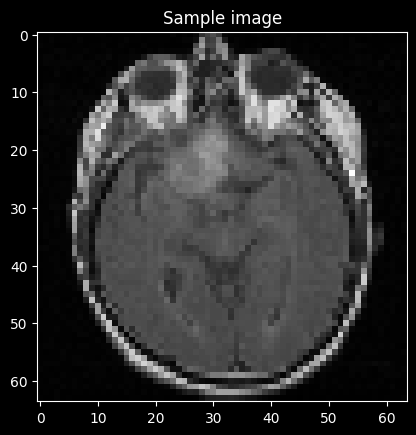

In [7]:

plt.title('Sample image')
plt.imshow(imgs[3], cmap='gray')
print('image shape: ', imgs[3].shape)

In [8]:
# Functions to add noise to image
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)

    # Add salt noise
    num_salt = np.ceil(salt_prob * image.size).astype(int)
    salt_coords = [np.random.randint(0, high=image.shape[0], size=num_salt),
                   np.random.randint(0, high=image.shape[1], size=num_salt)]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise
    num_pepper = np.ceil(pepper_prob * image.size).astype(int)
    pepper_coords = [np.random.randint(0, high=image.shape[0], size=num_pepper),
                     np.random.randint(0, high=image.shape[1], size=num_pepper)]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

def add_gaussian_noise(image, mean=0, stddev=2):
    noisy_image = image.copy()

    noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image[:, :], noise)
    
    return noisy_image

def add_speckle_noise(image, stddev=0.1):
    noisy_image = image.copy()
    
    noise = np.random.normal(0, stddev, image.shape)
    noisy_image[:, :] = np.uint8(np.clip(image[:, :] + image[:, :] * noise, 0, 255))
    
    return noisy_image

def add_poisson_noise(image, scale):
    noisy_image = image.copy()

    noise = np.random.poisson(scale, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)

    return noisy_image

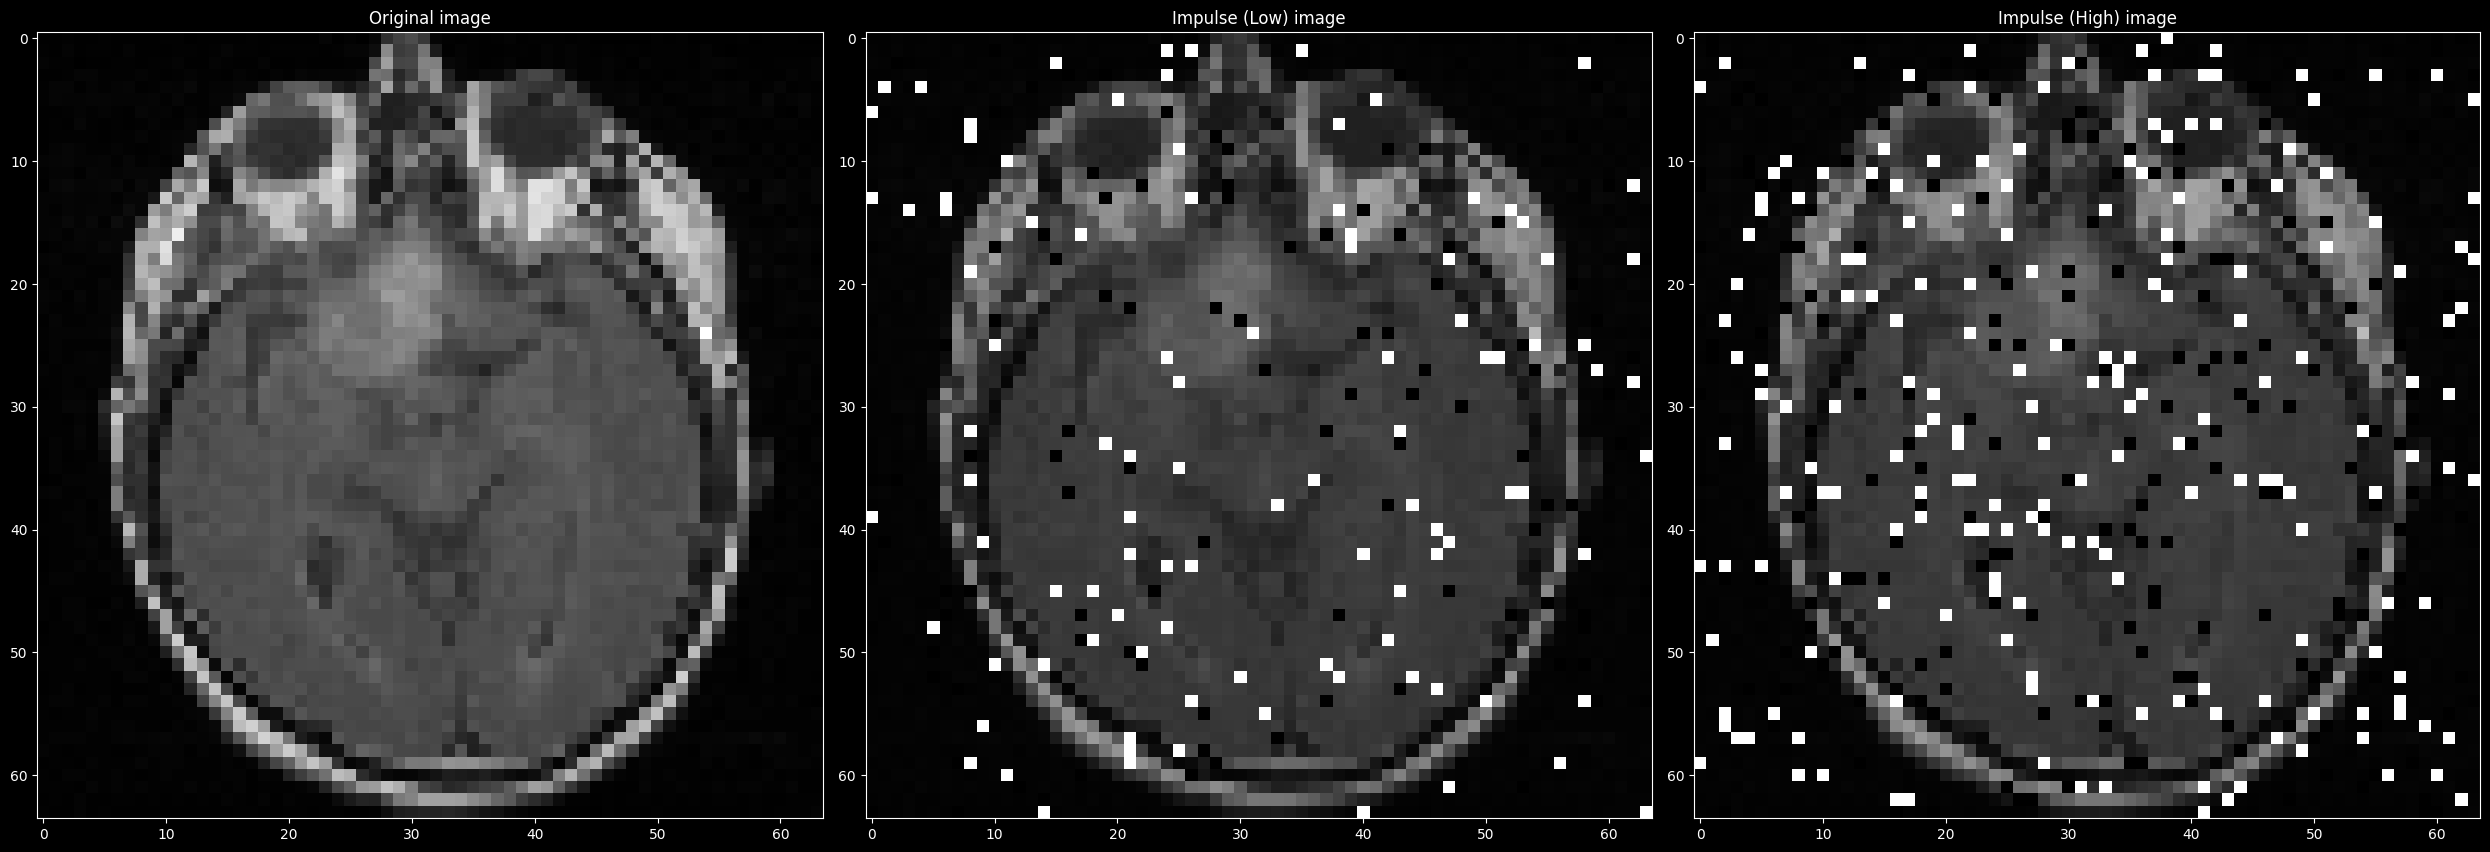

In [9]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]
fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Impulse (Low) image')
axes[1].imshow(add_salt_and_pepper_noise(test_img, IMPULSE_LOW_PROBABILITY, IMPULSE_LOW_PROBABILITY), cmap='gray')  

axes[2].set_title('Impulse (High) image')
axes[2].imshow(add_salt_and_pepper_noise(test_img, IMPULSE_HIGH_PROBABILITY, IMPULSE_HIGH_PROBABILITY), cmap='gray')  

plt.tight_layout()  
plt.show()

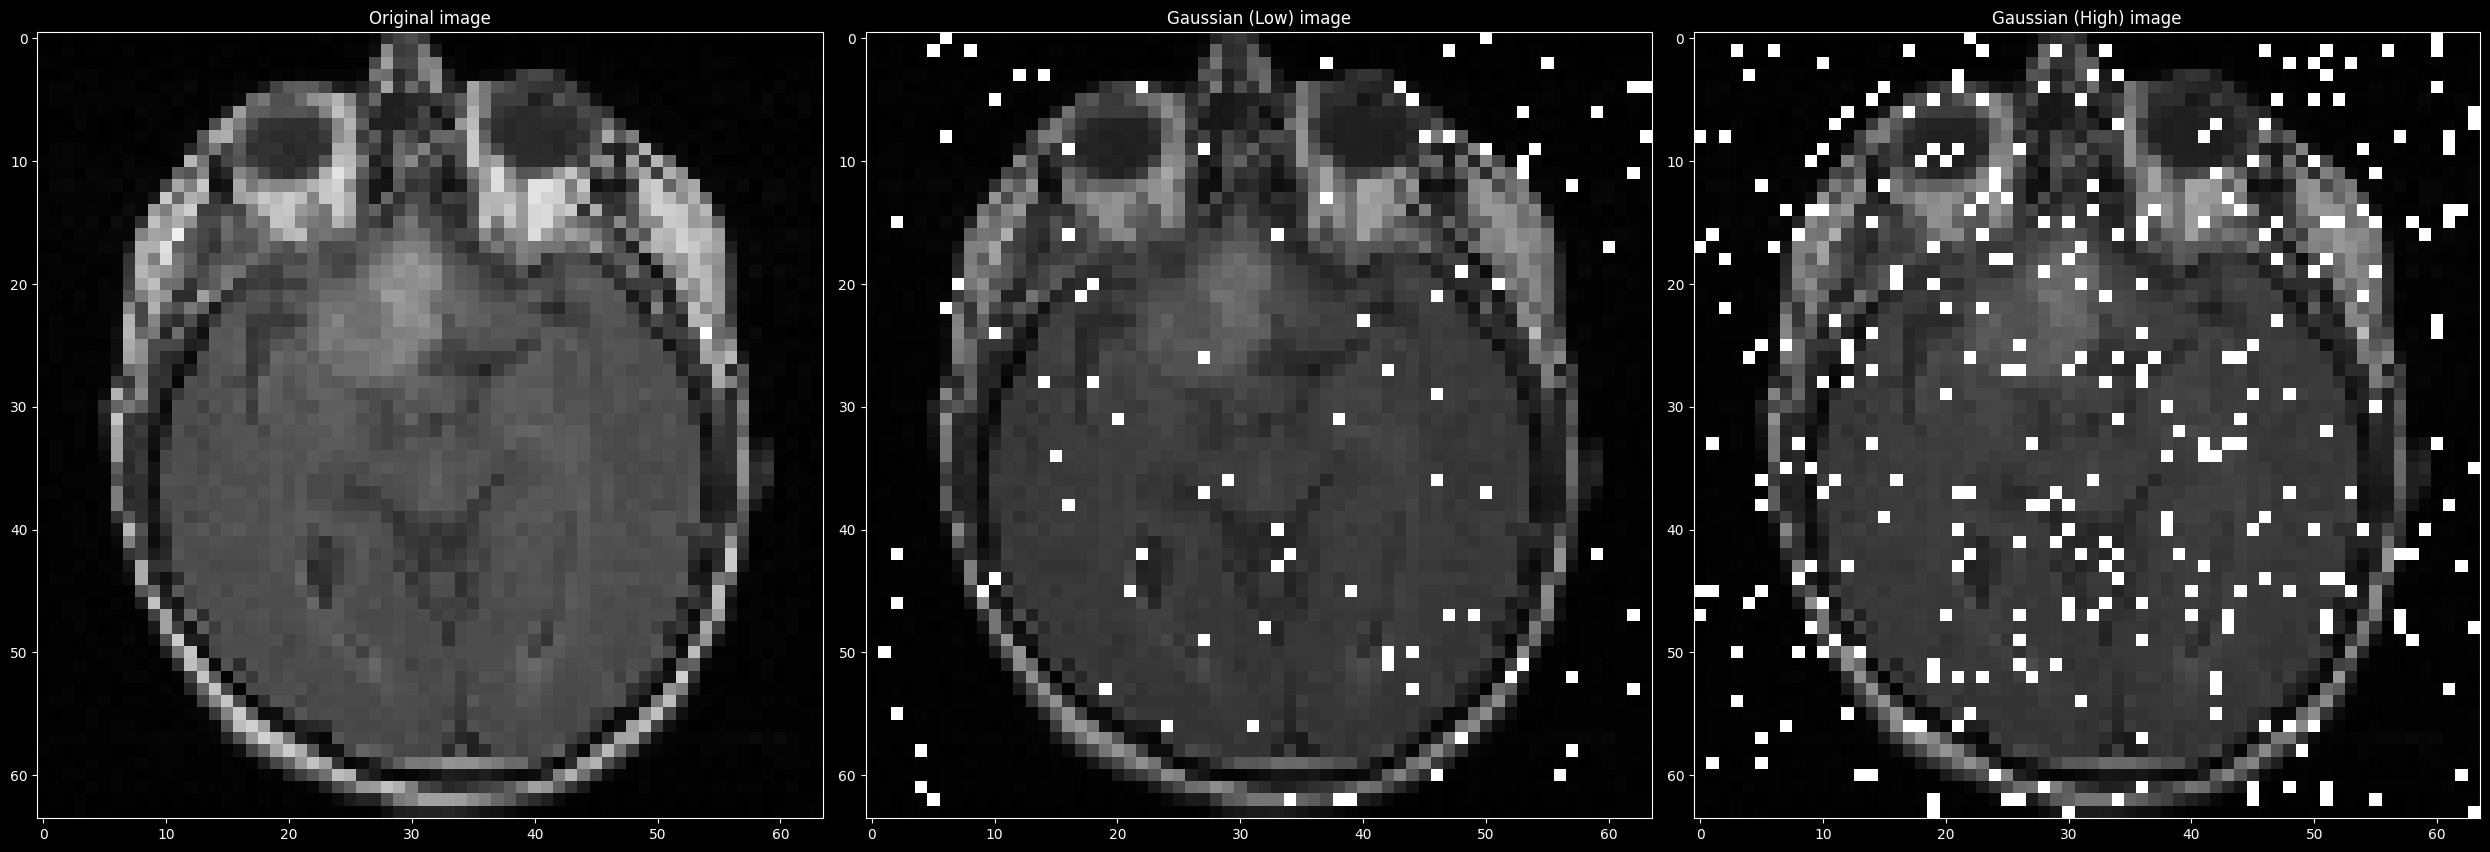

In [10]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Gaussian (Low) image')
axes[1].imshow(add_gaussian_noise(test_img, 0, GAUSSIAN_LOW_SIGMA), cmap='gray')  

axes[2].set_title('Gaussian (High) image')
axes[2].imshow(add_gaussian_noise(test_img, 0, GAUSSIAN_HIGH_SIGMA), cmap='gray')  

plt.tight_layout()  
plt.show()

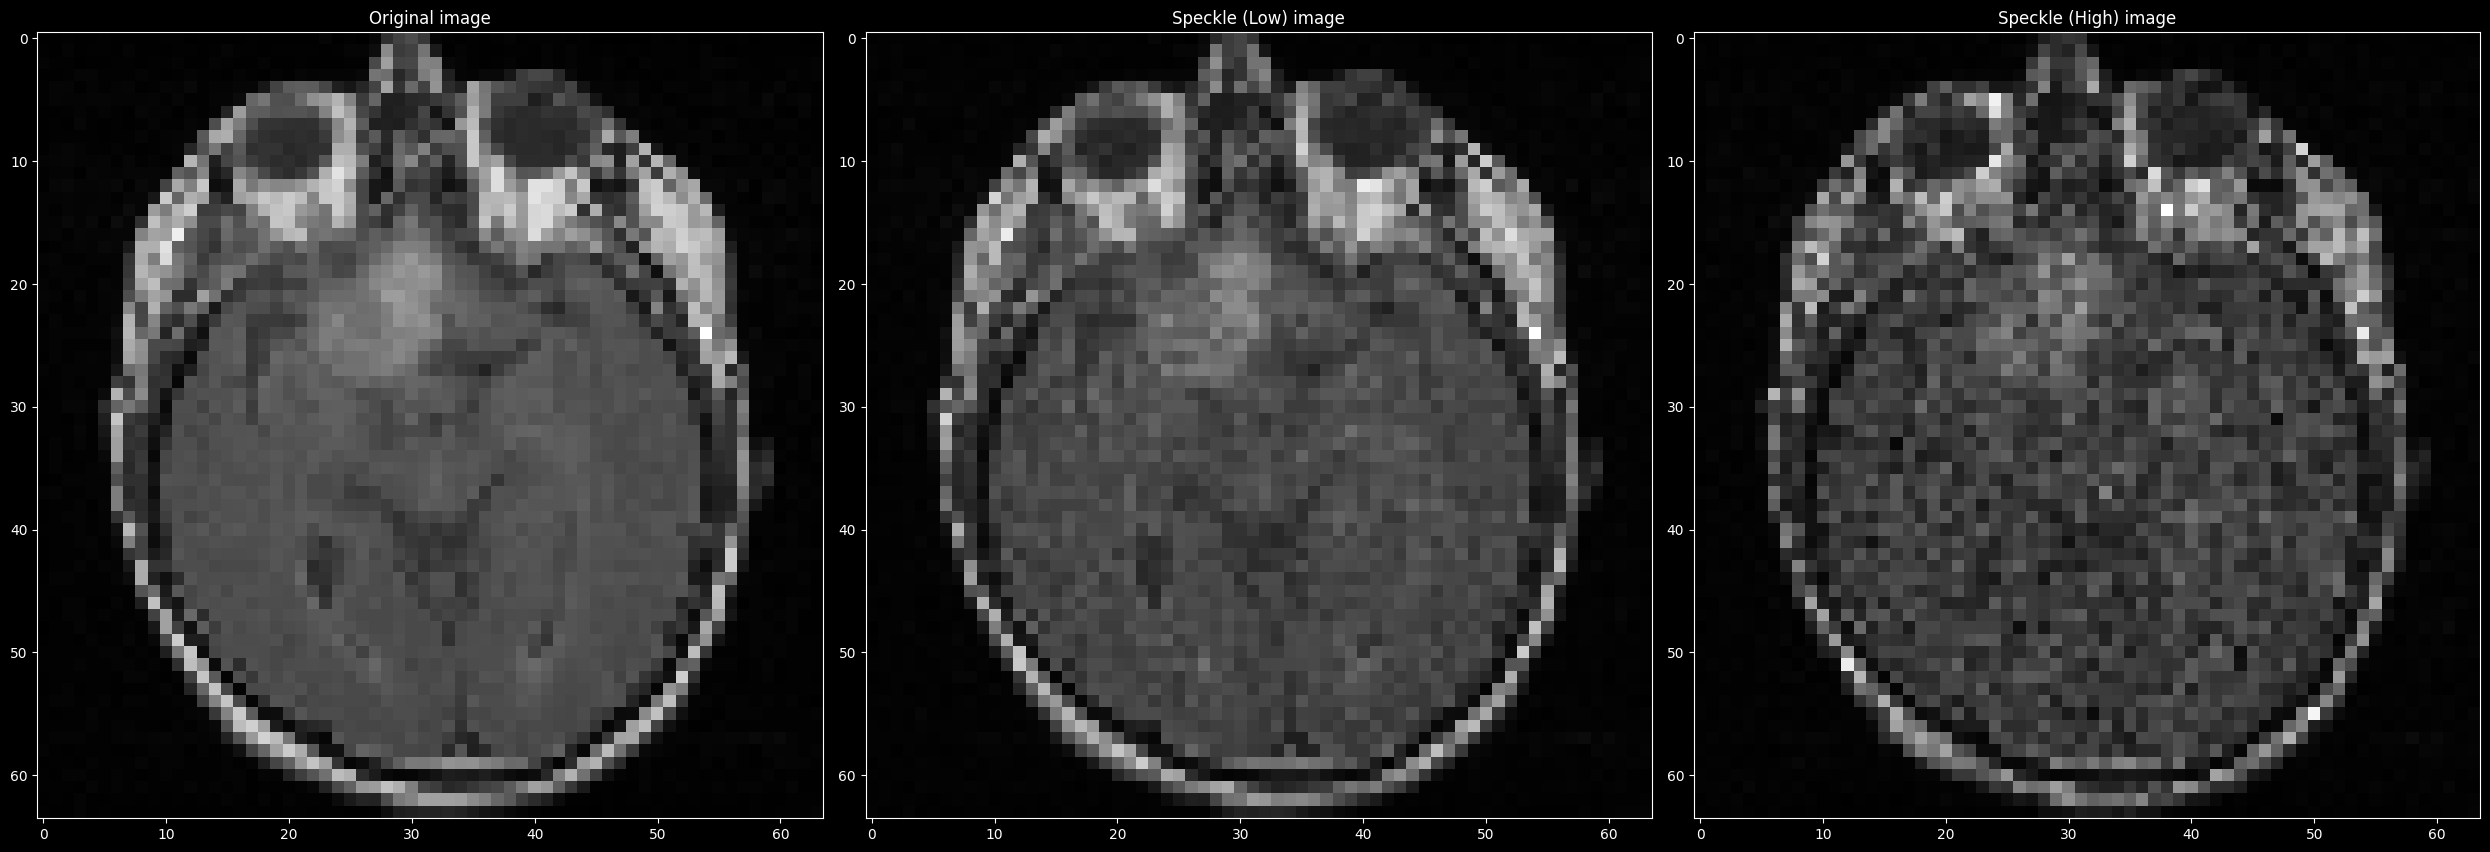

In [11]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Speckle (Low) image')
axes[1].imshow(add_speckle_noise(test_img, SPECKLE_LOW_PROBABILITY), cmap='gray')  

axes[2].set_title('Speckle (High) image')
axes[2].imshow(add_speckle_noise(test_img, SPECKLE_HIGH_PROBABILITY), cmap='gray')  

plt.tight_layout()  
plt.show()

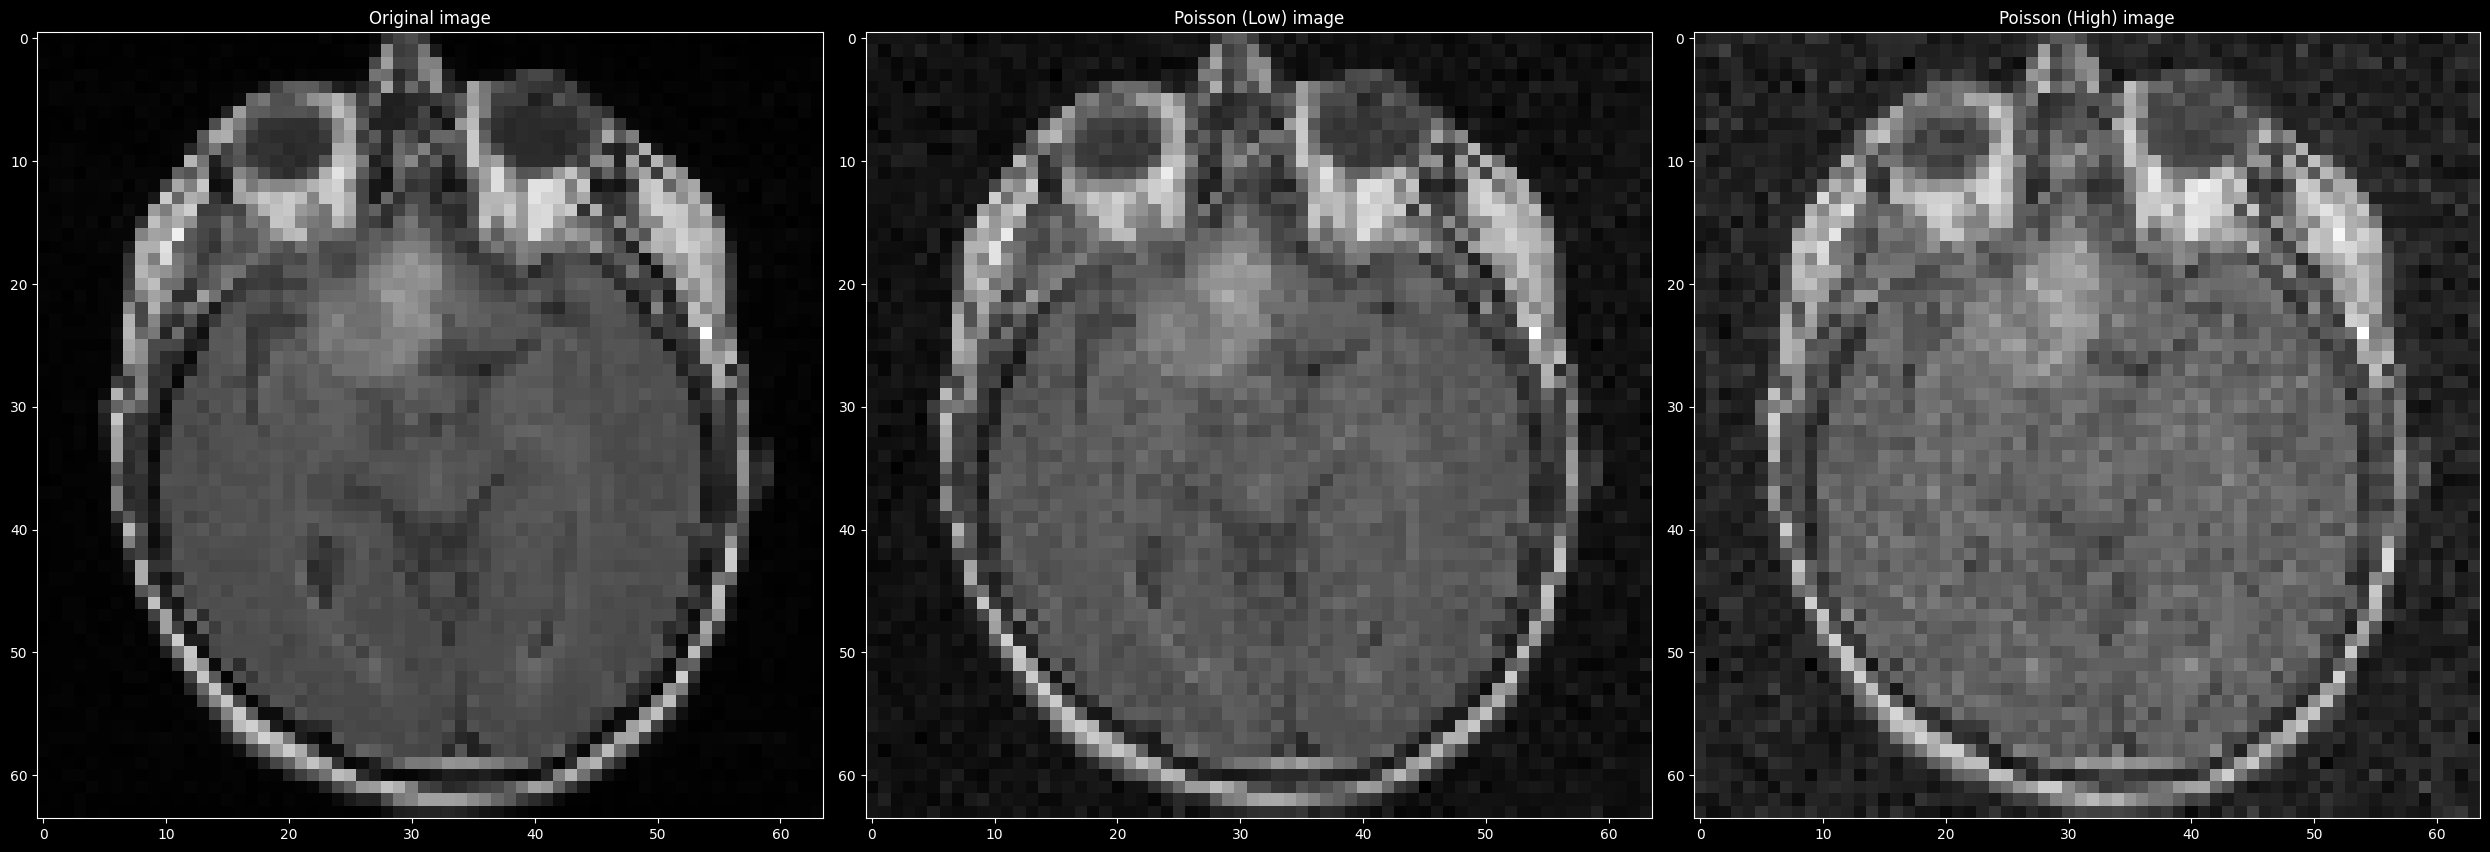

In [12]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Poisson (Low) image')
axes[1].imshow(add_poisson_noise(test_img, 2e+1), cmap='gray')  

axes[2].set_title('Poisson (High) image')
axes[2].imshow(add_poisson_noise(test_img, 70), cmap='gray')  

plt.tight_layout()  
plt.show()

In [13]:
# Image augmentation (Horizontal / Vertical flip / 45 degree rotation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)

In [14]:
# Setup training data
x_data = []
y_data = []

for img in imgs:
    # Impulse
    original_img = add_salt_and_pepper_noise(img, IMPULSE_LOW_PROBABILITY, IMPULSE_LOW_PROBABILITY)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_IMPULSE)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_IMPULSE] * len(augmented_imgs))

    # Impulse
    original_img = add_salt_and_pepper_noise(img, IMPULSE_HIGH_PROBABILITY, IMPULSE_HIGH_PROBABILITY)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_IMPULSE)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_IMPULSE] * len(augmented_imgs))

    # Gaussian
    original_img = add_gaussian_noise(img, 0, GAUSSIAN_LOW_SIGMA)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_GAUSSIAN)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_GAUSSIAN] * len(augmented_imgs))

    # Gaussian
    original_img = add_gaussian_noise(img, 0, GAUSSIAN_HIGH_SIGMA)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_GAUSSIAN)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_GAUSSIAN] * len(augmented_imgs))

    # Speckle
    original_img = add_speckle_noise(img, SPECKLE_LOW_PROBABILITY)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_SPECKLE)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_SPECKLE] * len(augmented_imgs))

    # Speckle
    original_img = add_speckle_noise(img, SPECKLE_HIGH_PROBABILITY)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_SPECKLE)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_SPECKLE] * len(augmented_imgs))

    # Poisson
    original_img = add_poisson_noise(img, 2e+1)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_POISSON)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_POISSON] * len(augmented_imgs))

    # Poisson
    original_img = add_poisson_noise(img, 70)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_POISSON)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_POISSON] * len(augmented_imgs))


In [15]:
x_data = np.array(x_data)
y_data = np.array(y_data)

x_data = np.expand_dims(x_data, axis=3) / 255.0

print('x_data len: ', len(x_data))
print('x shape: ', x_data[0].shape)
print('y_data len: ', len(y_data))

x_data len:  32000
x shape:  (64, 64, 1)
y_data len:  32000


In [16]:
# Splitting data into train, test and validation

from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=104, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=104, test_size=0.25)

In [17]:
# Make the 256, 256 images into 256, 256, 1
x_train
print(x_train.shape)

(18000, 64, 64, 1)


In [18]:
print('x train len ', len(x_train))
print('x test len ', len(x_test))
print('x val len ', len(x_val))
print('x train image shape', x_train[1].shape)
print('y train len ', len(y_train))

x train len  18000
x test len  8000
x val len  6000
x train image shape (64, 64, 1)
y train len  18000


In [19]:
# Convert y data to categorical
#y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
#y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)

print(y_train[0])

3


In [20]:
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=4)

Epoch 1/10
4500/4500 [==============================] - 56s 12ms/step - loss: 0.3908 - accuracy: 0.7808 - val_loss: 0.3767 - val_accuracy: 0.7590
Epoch 2/10
4500/4500 [==============================] - 53s 12ms/step - loss: 0.3107 - accuracy: 0.8263 - val_loss: 0.3315 - val_accuracy: 0.8105
Epoch 3/10
4500/4500 [==============================] - 52s 12ms/step - loss: 0.2599 - accuracy: 0.8732 - val_loss: 0.3723 - val_accuracy: 0.8008
Epoch 4/10
4500/4500 [==============================] - 53s 12ms/step - loss: 0.2101 - accuracy: 0.9053 - val_loss: 0.3693 - val_accuracy: 0.8260
Epoch 5/10
4500/4500 [==============================] - 53s 12ms/step - loss: 0.1540 - accuracy: 0.9366 - val_loss: 0.4525 - val_accuracy: 0.8377
Epoch 6/10
4500/4500 [==============================] - 53s 12ms/step - loss: 0.1050 - accuracy: 0.9603 - val_loss: 0.4424 - val_accuracy: 0.8398
Epoch 7/10
4500/4500 [==============================] - 58s 13ms/step - loss: 0.0879 - accuracy: 0.9698 - val_loss: 0.5636 -

In [21]:
metrics = model.evaluate(x_test, y_test)
print(metrics)

250/250 [==============================] - 3s 11ms/step - loss: 0.6213 - accuracy: 0.8615
[0.621282696723938, 0.8615000247955322]


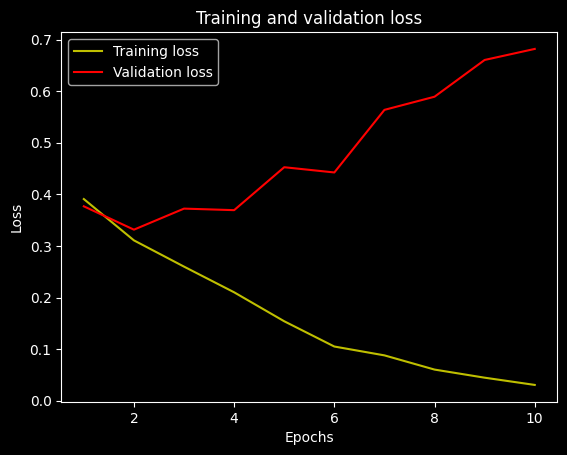

{'loss': [0.39081522822380066, 0.310747355222702, 0.2598797678947449, 0.2101287990808487, 0.1539841592311859, 0.10503773391246796, 0.08790324628353119, 0.06037729233503342, 0.0446547195315361, 0.030631816014647484], 'accuracy': [0.7808333039283752, 0.8262777924537659, 0.8731666803359985, 0.9053333401679993, 0.9365555644035339, 0.960277795791626, 0.9697777628898621, 0.9768333435058594, 0.9827222228050232, 0.9891666769981384], 'val_loss': [0.3767341673374176, 0.3315012454986572, 0.37229225039482117, 0.3693057894706726, 0.4524976313114166, 0.4423561990261078, 0.563647985458374, 0.589137077331543, 0.6603450775146484, 0.6817509531974792], 'val_accuracy': [0.7590000033378601, 0.8105000257492065, 0.8008333444595337, 0.8259999752044678, 0.8376666903495789, 0.8398333191871643, 0.8401666879653931, 0.843833327293396, 0.8441666960716248, 0.8504999876022339]}


In [22]:
history = hist

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(history.history)

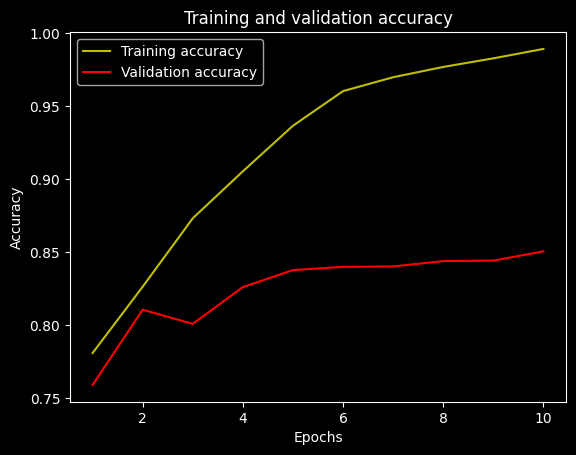

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

250/250 [==============================] - 3s 11ms/step
y pred :  [6.5584303e-25 1.1659672e-19 5.2030312e-17 1.0000000e+00]
actual noise type (index) :  3


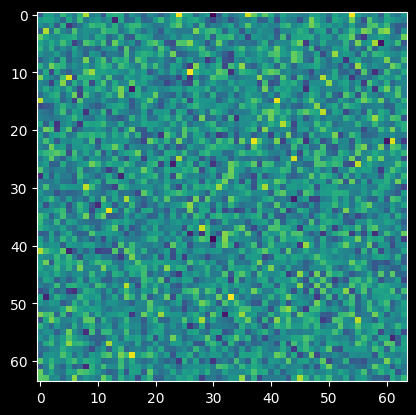

y pred :  [9.9956125e-01 4.3876775e-04 5.3862341e-09 2.9988872e-12]
actual noise type (index) :  0


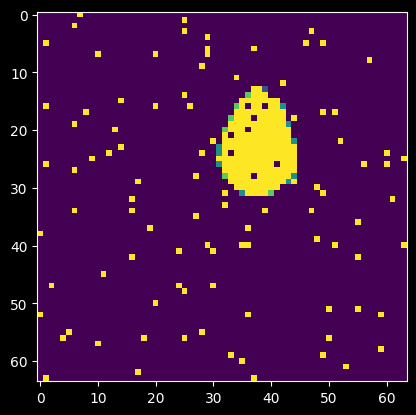

y pred :  [2.7558329e-11 1.0000000e+00 8.9829792e-15 3.9110761e-13]
actual noise type (index) :  1


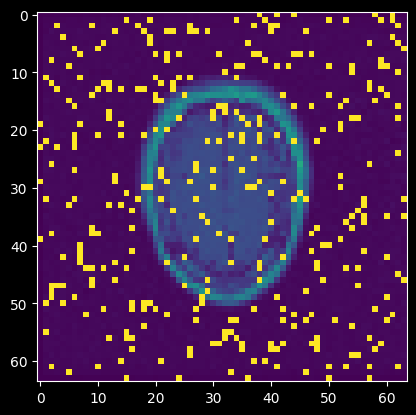

y pred :  [1.03637794e-22 1.63840662e-15 9.99339640e-01 6.60381687e-04]
actual noise type (index) :  2


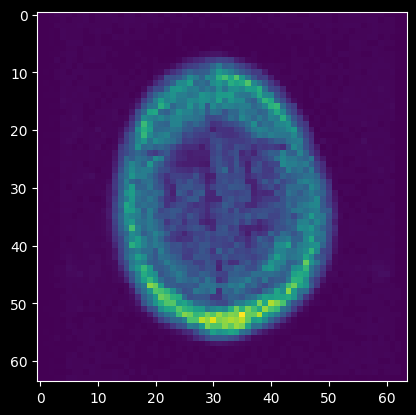

y pred :  [5.9461654e-03 9.9405330e-01 4.8928285e-07 1.7511675e-09]
actual noise type (index) :  0


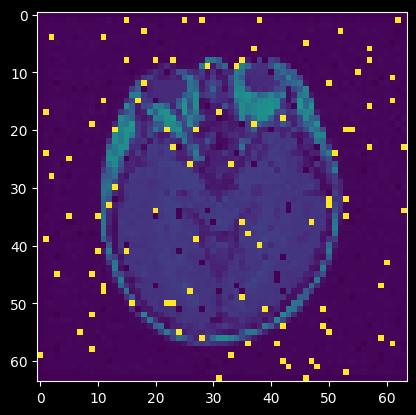

y pred :  [1.3923907e-21 1.4555940e-13 4.7564504e-04 9.9952435e-01]
actual noise type (index) :  3


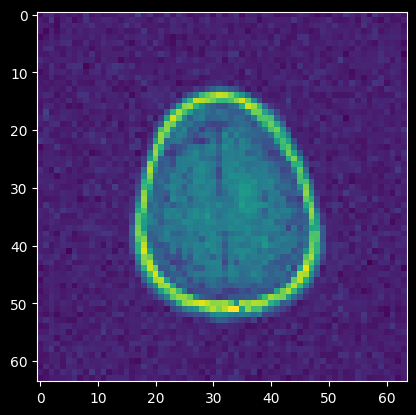

y pred :  [3.4942477e-26 4.3876140e-21 9.9984956e-01 1.5037428e-04]
actual noise type (index) :  2


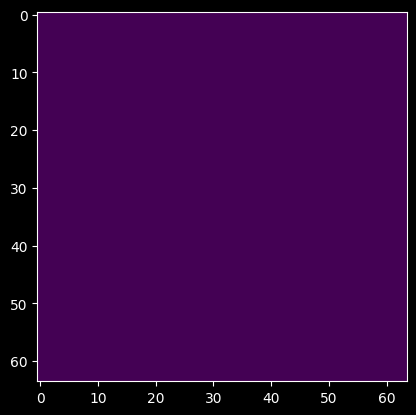

y pred :  [1.4805746e-01 8.5194075e-01 1.8508380e-06 4.6320729e-08]
actual noise type (index) :  0


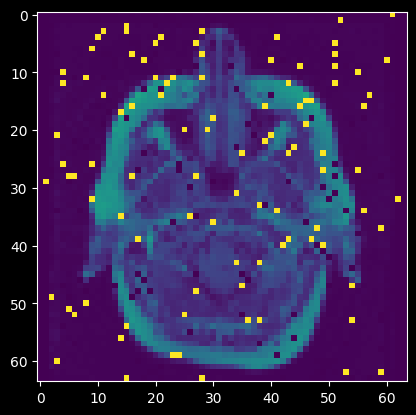

y pred :  [9.5469923e-20 4.6089811e-15 9.9982005e-01 1.7999043e-04]
actual noise type (index) :  2


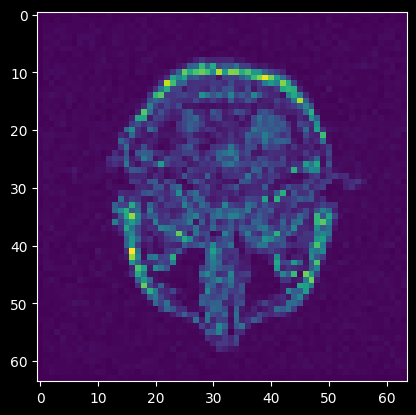

y pred :  [1.9481581e-17 2.0814302e-11 6.2880771e-19 1.0000000e+00]
actual noise type (index) :  3


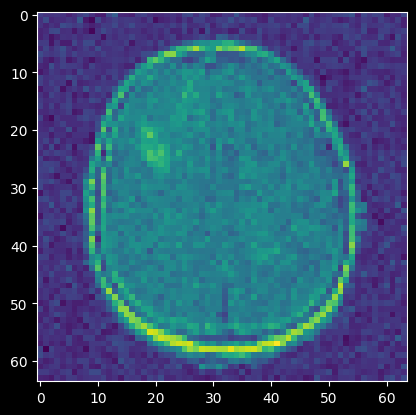

In [28]:
# Some predictions to see how the model performs.
y_pred=model.predict(x_test)

for i in range(10):
    plt.imshow(x_test[i])
    print('y pred : ', y_pred[i])
    print('actual noise type (index) : ', y_test[i])
    plt.show()